# Assignment, Quantum Machine Learning, Vasileios Katsaitis
### ΑΜ: 1115202000073


In [21]:
!pip install pennylane
!pip install qutip

In [22]:
# Importing the required libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import autograd.numpy as anp # We will be using the autograd version of numpy for the variational quantum classifier since it helps in automatic differentiation using the PennyLane library
 
# Importing necessary libraries for the variational quantum classifier
# For that purpose, we will be using the PennyLane library which is a quantum machine learning library
import pennylane as qml
from pennylane import numpy as pnp # We will also be using the numpy module from PennyLane for specific quantum operations
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam, SGD 
from keras.losses import MeanSquaredError
from pylab import *
from qutip import *

In [23]:
# In this code cell, we will be importing our data from the respective binary .dat files

#* Data collection
# General notion here is to create a numpy array that consists of numpy arrays of the data from the .dat files
# The data will be stored in the form of a list of numpy arrays, each for every class and data type (training or testing)

class_A_training_data = [] 
class_A_testing_data = [] 
class_B_training_data = []
class_B_testing_data = [] 

# NOTE: Lists above contain arrays of 5 input data on their FIRST position, and 3 input data on their SECOND position.
# This is a convention made, when traversing these binary files, to store the data in the order they're sorted it in currect directory.

# Traversing current directory to get the .dat files
for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".dat"):
                        
            # Read the data from the .dat files
            data = np.fromfile(os.path.join(root, file), dtype = np.float32)

            # If the file is from class A, store the data in class_A_data
            if "A" in file:
                if "test" not in file:
                    class_A_training_data.append(data)
                else:
                    class_A_testing_data.append(data)
                    
            elif "B" in file:
                if "test" not in file:
                    class_B_training_data.append(data)
                else:
                    class_B_testing_data.append(data)


In [24]:
# In this code cell, we will aim to visualize the data we have imported from the .dat files, upon pre-processing it.

#* Data pre-processing
# General notion here is to convert the data from the list of numpy arrays to a pandas dataframe
# This will allow us to visualize the data in a more structured manner

# We define a function that takes care of the pre-processing of the data
# Function will take a data list as input and return its pre-processed version
def preprocess_data(data_list, epsilon = 1e-12):
    # We replace the NaN values with 0
    data_list = [np.nan_to_num(data) for data in data_list]
    
    # We subtract 0.5 from the data to center it around 0
    data_list = [data - 0.5 for data in data_list]
    
    # We standardize the data using the MinMaxScaler
    # The MinMaxScaler scales the data to a fixed range, so it is more suitable for our data than the StandardScaler
    # We, thus, scale the data to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data_list = [scaler.fit_transform(data.reshape(-1, 1)).reshape(-1) for data in data_list]
    scaled_data_list = [data + epsilon for data in scaled_data_list]
    
    return scaled_data_list

# Function that 

#* Visualizing the preprocessed data
# We define a function that takes care of the visualization of the data
# Function will take a data list as input and return its visualization as a scatter plot in 2D
def visualize_data(data):
    # Ensure the data has at least three elements
    if data.shape[0] < 3:
        raise ValueError("Data must have at least 3 elements for 3D plotting")
    
    # We, now, determine the length of the data to use for 3D plotting
    length = len(data) // 3 * 3  # Conventionally, we take the length of the data to be a multiple of 3
    
    # We split data into three equal parts for x, y, and z coordinates, respectively
    x = data[:length:3]
    y = data[1:length:3]
    z = data[2:length:3]
    
    # We, then, create a 3D scatter plot of the data
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(x, y, z)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.title('3D Scatter Plot')
    plt.show()
   
    return 


 ------------------------- CLASS A TRAINING DATA -------------------------- 


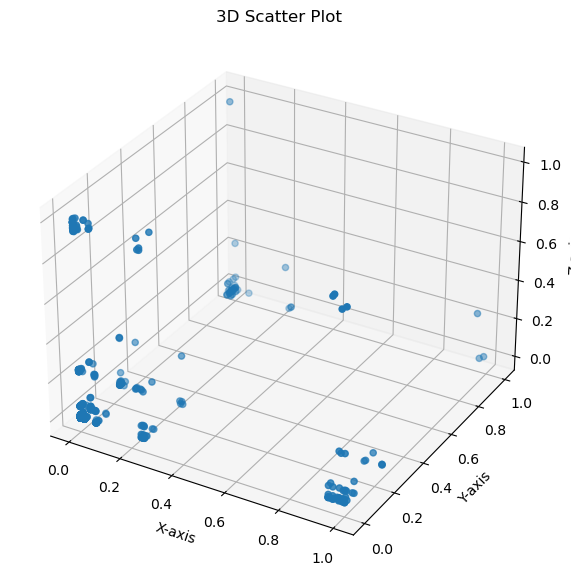

 ------------------------- CLASS A TESTING DATA --------------------------- 


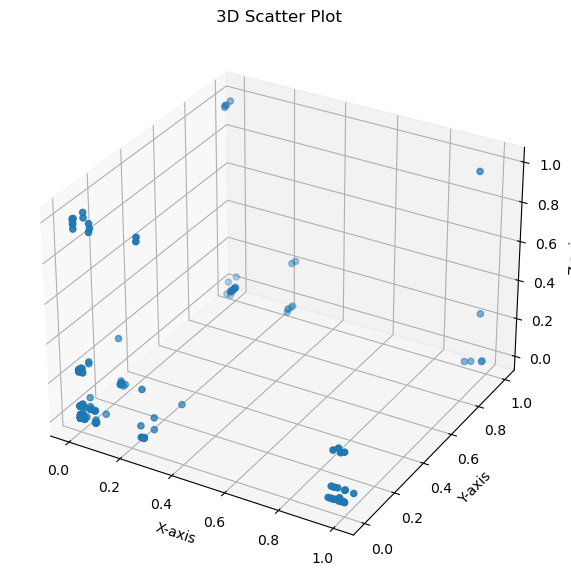

 ------------------------- CLASS B TRAINING DATA -------------------------- 


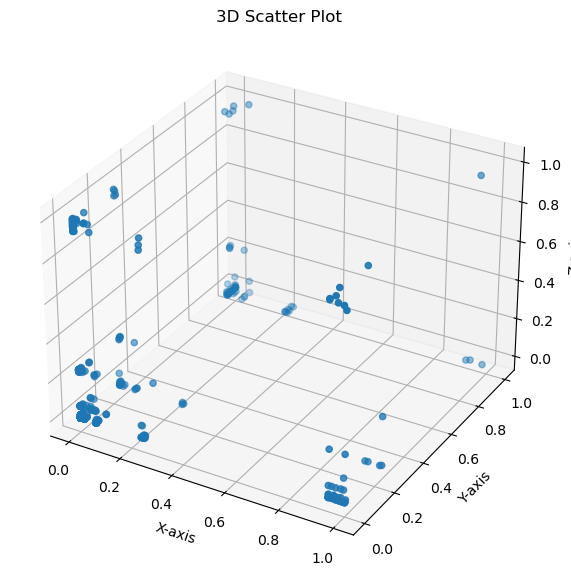

 ------------------------- CLASS B TESTING DATA --------------------------- 


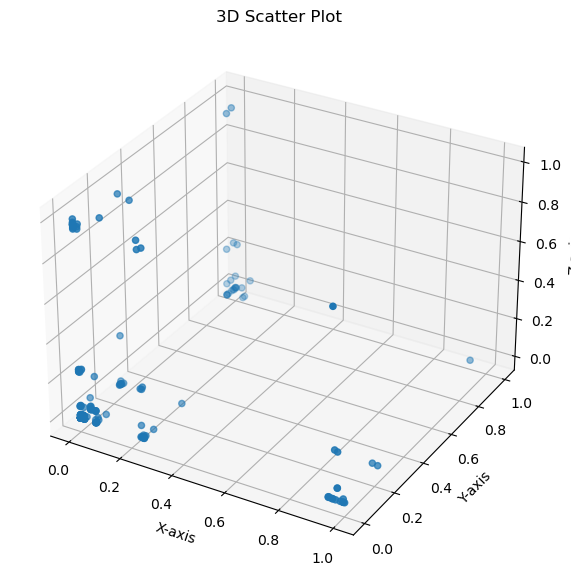

In [25]:
# We call respective functions to pre-process and visualize the data (for 3 inputs)

#* Calling function to pre-process the data
class_A_training_data = preprocess_data(class_A_training_data)
class_A_testing_data = preprocess_data(class_A_testing_data)
class_B_training_data = preprocess_data(class_B_training_data)
class_B_testing_data = preprocess_data(class_B_testing_data)


#* Calling function to visualize the data
print(" ------------------------- CLASS A TRAINING DATA -------------------------- ")
visualize_data(class_A_training_data[1])
print(" ------------------------- CLASS A TESTING DATA --------------------------- ")
visualize_data(class_A_testing_data[1])
print(" ------------------------- CLASS B TRAINING DATA -------------------------- ")
visualize_data(class_B_training_data[1])
print(" ------------------------- CLASS B TESTING DATA --------------------------- ")
visualize_data(class_B_testing_data[1])

In [26]:

#* Complemetary code cell for data conversion.

# We define this function that receives a data list, as input, and returns the respective array of arrays, where every inner array is a point of R^dim.
# Default dim value is 3, as we are mostly working in R3.
def data_shape_conversion(data, dim = 3):
    # We ensure that the data has at least "dim" elements
    if data.shape[0] < dim:
        raise ValueError(f"Data must have at least {dim} elements for {dim}D plotting")
    
    # We, now, determine the length of the data to use for our plotting
    length = len(data) // dim * dim  # Conventionally, we take the length of the data to be a multiple of "dim"
    
    # We split data into "dim" equal parts to get the respective coordinates
    coordinate_list = []
    for i in range(dim):
        coordinate_list.append(data[i:length:dim])
    
    # We create a list of arrays, where every inner array is a point of R^dim
    Rdim_data = [[coordinate_list[i][j] for i in range(dim)] for j in range(len(coordinate_list[0]))]
    
    # We convert the list to a numpy array
    Rdim_data = np.array(Rdim_data)
    
    return Rdim_data

In [27]:

#* Data shape conversions (to R3 and R5)

# Converting the data to R3 (default dimension value in function call of "data_shape_conversion" is 3)
class_A_training_data_R3 = data_shape_conversion(class_A_training_data[1])
class_A_testing_data_R3 = data_shape_conversion(class_A_testing_data[1])
class_B_training_data_R3 = data_shape_conversion(class_B_training_data[1])
class_B_testing_data_R3 = data_shape_conversion(class_B_testing_data[1])

# Converting the data to R5
class_A_training_data_R5 = data_shape_conversion(class_A_training_data[0], 5)
class_A_testing_data_R5 = data_shape_conversion(class_A_testing_data[0], 5)
class_B_training_data_R5 = data_shape_conversion(class_B_training_data[0], 5)
class_B_testing_data_R5 = data_shape_conversion(class_B_testing_data[0], 5)

In [28]:

#* Training and testing data preparation

# Defining the training and testing data
data_A_train = class_A_training_data_R3
data_A_test = class_A_testing_data_R3
data_B_train = class_B_training_data_R3
data_B_test = class_B_testing_data_R3

# Combine and label the data
X_train = np.vstack((data_A_train, data_B_train))
X_test = np.vstack((data_A_test, data_B_test))
y_train = np.array([np.sum(x) % 2 for x in X_train.round().astype(int)])
y_test = np.array([np.sum(x) % 2 for x in X_test.round().astype(int)])


In [29]:
# In the following code cells, we will be implementing the variational quantum classifier for the given dataset.
# This quantum circuit will essentially solve the parity problem for the given dataset (initially only using 3 bit inputs).

# We define the number of qubits to be used in the quantum circuit
n_qubits = 4

# We define the device to be used for the quantum circuit
dev = qml.device("default.qubit", wires = n_qubits)

#* Subquestion 1.a - Implementing the variational quantum classifier for 3 quantum bits (3 inputs)

# We, initially, define the quantum node that will be used to create the quantum circuit
# This is an important addition to the PennyLane library, as it allows us to define quantum circuits as QNodes.
# @qml.qnode(dev, interface = 'autograd', diff_method = 'parameter-shift') # Comment in if you intend to test out the parameter shift method
@qml.qnode(dev, interface = 'autograd')

# Our task, now, is to define the quantum circuit that will be used for the variational quantum classifier
# NOTE: We use the AmplitudeEmbedding function to embed the input data x into the quantum circuit (since they're floats).
# However, since a lot of the data is 0, when we pad it with 0 and normalize it, it might cause some divisions by 0. 
# Argument 'params' is used to specify the parameters (or weights) of the model, 'x' is the input data, and 'n_qubits' is the number of qubits in the quantum circuit.
# Argument 'parameter_shift' is used to specify whether we want to use the parameter shift rule for the gradient calculation or not. 
# If set to True, the parameter shift rule is used and we only return the expectation value of the PauliZ operator on the first qubit. 
# If set to False, the default PennyLane gradient calculation method is used and we conventionally return the expectation value of the PauliZ operator on the first qubit and the quantum state. 
def variational_circuit(params, x, n_qubits = 3, parameter_shift = False):
    # We embed the input data x into the quantum circuit using the AmplitudeEmbedding function
    qml.AmplitudeEmbedding(x, wires = range(n_qubits), pad_with = 0.0, normalize = True)
    
    for parameters in params:
        # We apply the Rot gate to each qubit in the circuit (arbitrary single-qubit rotation)
        for i in range(n_qubits):
            qml.Rot(*parameters[i], wires = i) 
            
         # We apply the CNOT gate between every two consecutive qubits (entanglement)
        for i in range(n_qubits - 1):
            qml.CNOT(wires = [i, i + 1])
        
        qml.CNOT(wires = [n_qubits - 1, 0]) 
    
    
    # We only care about the first qubit, since we are solving a binary classification problem and don't want to add unnecessary complexity to our model
    if parameter_shift == True:
        return qml.expval(qml.PauliZ(0))
    
    return qml.expval(qml.PauliZ(0)), qml.state()
    
  
# We define the variational classifier that will be used to classify the input data
# Essentially, this function will take the parameters of the model, the bias, and the input data x
# Returned value is the expectation value of the PauliZ operator on the first qubit plus the bias term and it typically between -1 and 1
def variational_classifier(params, bias, x, n_qubits = 3, parameter_shift = False):
    if parameter_shift == True:
        return variational_circuit(params, x, n_qubits, parameter_shift) + bias
    return variational_circuit(params, x, n_qubits, parameter_shift)[0] + bias
    

# Bloch Sphere Functions
# We define the functions that will be used to plot the Bloch sphere representation of the quantum states

# Function to get the Bloch vector of a quantum state for a specific qubit.
# This function computes the 3D Bloch vector manually, using the density matrix of input quantum state.
def get_bloch_vector(state, qubit_index):
   # We trace out all qubits, except the qubit of interest
    density_matrix = np.outer(state, state.conj()) # We calculate the density matrix of the quantum state using the outer product of the state vector
    
    for i in range(n_qubits):
        if i != qubit_index:
            density_matrix = qml.math.trace(density_matrix.reshape([2, 2, -1]), axis1 = 0, axis2 = 1)
    
    # We, then, extract the coefficients of the density matrix
    rho_00 = density_matrix[0] # Coefficient of |0><0|
    rho_01 = density_matrix[1] # Coefficient of |0><1|
    rho_10 = density_matrix[2] # Coefficient of |1><0|
    rho_11 = density_matrix[3] # Coefficient of |1><1|

    # We calculate Bloch vector components
    x = 2 * np.real(rho_01) 
    y = 2 * np.imag(rho_10) 
    z = np.real(rho_00 - rho_11) 

    # We, finally, return the Bloch vector
    return np.array([x, y, z])


# Function to plot the Bloch sphere representation of the quantum states
def plot_bloch_sphere(bloch_vector, title):
    # Using the quTiP library to plot the Bloch sphere representation of the quantum states
    
    # We, first, create the Bloch sphere
    bloch_sphere = Bloch()
    
    # We add the Bloch vector to the Bloch sphere
    bloch_sphere.add_vectors(bloch_vector)
    
    # We set the title of the plot
    bloch_sphere.title = title
    
    # We, then, show the Bloch sphere plot
    bloch_sphere.show()
    
    return


# Loss functions

# Binary Cross-Entropy Loss Function
def binary_cross_entropy(y_true, y_pred):
    y_pred = anp.array(y_pred)
    # We clip the predicted values by a small epsilon value to avoid log(0) and log(1) in the loss function
    y_pred = anp.clip(y_pred, 1e-12, 1 - 1e-12) # Comment in whenever you're using the NesterovMomentumOptimizer as the optimization function 
    # We calculate the probability of the model predicting the correct label (just like in Petruccione and Schuld's book)
    probability = 0.5 * (1 + y_pred)
    # We calculate the binary cross-entropy loss
    loss = -y_true * anp.log(probability) - (1 - y_true) * anp.log(1 - probability)
    return anp.mean(loss)

# Mean Squared Error (MSE) Loss Function
def mean_squared_error(y_true, y_pred):
    y_pred = anp.array(y_pred)
    return anp.mean((y_true - y_pred) ** 2)

# Hinge Loss Function
def hinge_loss(y_true, y_pred):
    y_pred = anp.array(y_pred)
    return anp.mean(anp.maximum(0, 1 - y_true * y_pred))

# Log-Cosh Loss Function
def log_cosh_loss(y_true, y_pred):
    y_pred = anp.array(y_pred)
    return anp.mean(anp.log(anp.cosh(y_pred - y_true)))

# Huber Loss Function
def huber_loss(y_true, y_pred, delta = 1.0):
    y_pred = anp.array(y_pred)
    return anp.mean(anp.where(anp.abs(y_true - y_pred) < delta, 0.5 * (y_true - y_pred) ** 2, delta * (anp.abs(y_true - y_pred) - 0.5 * delta)))

# Accuracy Function
# We also define the accuracy function that will be used to calculate the accuracy of the model
def accuracy(y_true, y_pred):
    return anp.mean(anp.equal(y_true, anp.round(y_pred)))



#* Subquestion 1.b - Defining the cost function for the variational quantum classifier
# We define the cost function that will be used to calculate the cost of the model
# There are two classes in the dataset, so we will use the binary cross-entropy loss function, which is the most suitable for binary classification problems
def cost(params, bias, X, Y, n_qubits = 3, parameter_shift = False):
    predictions = [variational_classifier(params, bias, x, n_qubits, parameter_shift) for x in X]
    # return binary_cross_entropy(Y, predictions)
    return mean_squared_error(Y, predictions)
    # return hinge_loss(Y, predictions)
    # return log_cosh_loss(Y, predictions)
    # return huber_loss(Y, predictions, delta = 1.0)


#* Subquestion 1.c - Defining the optimizer for the variational quantum classifier
# We use the Adam optimizer for the variational quantum classifier as it is the most commonly used for optimization problems (uses adaptive learning rates).
# This is a gradient-based optimization algorithm that is used to update the weights (parameters) of the model, in order to minimize the loss function.
# It is, therefore, going to be used in the first step of the training process.
step_size = 0.001
# step_size = 0.01
# optimizer = qml.AdamOptimizer(stepsize = step_size)
optimizer = qml.NesterovMomentumOptimizer(stepsize = step_size, momentum = 0.9)
# optimizer = qml.AdagradOptimizer(stepsize = step_size)
# optimizer = qml.RMSPropOptimizer(stepsize = step_size)

#* Subquestion 1.d - Training the variational quantum classifier (VQC) and calculating the accuracy of the model on training and testing data
# We, finally, define our alternative model training function that will be used to train the VQC

#* Argument definitions:
# For this model, we take the previously defined cost and accuracy functions, as well as the optimizer
# We, conventionally, set the number of epochs to 10, the batch size to 5, and the bias to 0.0 (we use batches to speed up the training process).
# Argument 'get_vectors' is used to specify whether we intend to plot the Bloch sphere representation of the quantum states or not. If True, this function ALSO returns a numpy array 
# of the Bloch vectors of every quantum state, to be plotted later on. This does not happen, when argument is set to False (default value).
# The 'class_A_size' parameter are used to specify the number of training data points in each class (which we need for the bloch sphere visualization, if specified).
# The 'num_random_points' parameter is used to specify the number of random input data points to be picked from the training data for the Bloch sphere visualization for EACH CLASS.
# The 'parameter_shift' parameter is used to specify whether we want to use the parameter shift rule for the gradient calculation or not. If set to True, the parameter shift rule is used. If set to False, the default PennyLane gradient calculation method is used.
# Function always returns the optimized parameters of the VQC.
def train_VQC(X_train, Y_train, X_test, Y_test, params, bias = 0.0, epochs = 10, batch_size = 10,  n_qubits = 3, get_vectors = False, class_A_size = 676, num_random_points = 3, parameter_shift = False):
    # We define the list we're going to add the Bloch vectors to.
    # The reasoning behind initializing this list outside is that we want to return an empty list if get_vectors is False.
    bloch_vectors = []
    for i in range(epochs):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = X_train[batch_index]
        Y_batch = Y_train[batch_index]
        
        # We use the optimizer to update the parameters of the model, based on the batch of training data points and their respective labels         
        params, bias = optimizer.step(cost, params, bias, X = X_batch, Y = Y_batch, n_qubits = n_qubits, parameter_shift = parameter_shift)

        # We calculate the accuracy of the model on the training data
        train_predictions = [np.round(variational_classifier(params, bias, x, n_qubits, parameter_shift)) for x in X_train]
        accuracy_train = accuracy(Y_train, train_predictions)
        train_loss = cost(params, bias, X_train, Y_train, n_qubits)
        
        # We calculate the accuracy of the model on the testing data
        test_predictions = [np.round(variational_classifier(params, bias, x, n_qubits, parameter_shift)) for x in X_test]
        accuracy_test = accuracy(Y_test, test_predictions)
        test_loss = cost(params, bias, X_test, Y_test, n_qubits)
        
        # We convert tensor variables to floats for printing purposes
        accuracy_train = accuracy_train.item()
        accuracy_test = accuracy_test.item()
        train_loss = train_loss.item()
        test_loss = test_loss.item()

        print(f"Epoch {i + 1} --- Training Accuracy: {accuracy_train * 100:.2f}% --- Testing Accuracy: {accuracy_test * 100:.2f}% --- Training Loss: {train_loss:.4f} --- Testing Loss: {test_loss:.4f}")
        
        if get_vectors and i % 5 == 0: # We get the Bloch vectors of the quantum states every 5 epochs
            # We randomly pick 3 input data points from the training data and concatenate them to get 6 random indices.
            # This is done to get a better representation of the quantum states on the Bloch sphere, without using too many input data points.
            # As one might be able to tell, we randomly pick our points every 5 epochs. This means that we're not necessarily getting the exact
            # same states every 5 epochs. This is done, in order to have a broader understanding of how our model performs for a variety of different quantum states
            # (that correspond to different class points).
            random_indices_A = np.random.choice(len(X_train[:class_A_size]), num_random_points, replace = False)
            random_indices_B = np.random.choice(len(X_train[class_A_size:]), num_random_points, replace = False)
            random_indices = np.concatenate((random_indices_A, random_indices_B))
            
            # We plot the Bloch sphere representation of the quantum states for the randomly picked input data points of class A
            X_train_random = X_train[random_indices]
            
            for x in X_train_random:
                _, state = variational_circuit(params, x, n_qubits, parameter_shift = False) # It doesn't matter whether we use parameter shifting or not, we just want to get the quantum states
                for j in range(n_qubits):
                    bloch_vectors.append(get_bloch_vector(state, j))
     
             
    # We convert the list to a numpy array
    bloch_vectors = np.array(bloch_vectors)  
          
    # We, finally, return both the optimized parameters and the Bloch vectors of the quantum states.
    # Obviously, if get_vectors is False, the function only returns the optimized parameters, as well as this empty list.
    return params, bloch_vectors


 Quantum Circuit:


Matplotlib is building the font cache; this may take a moment.


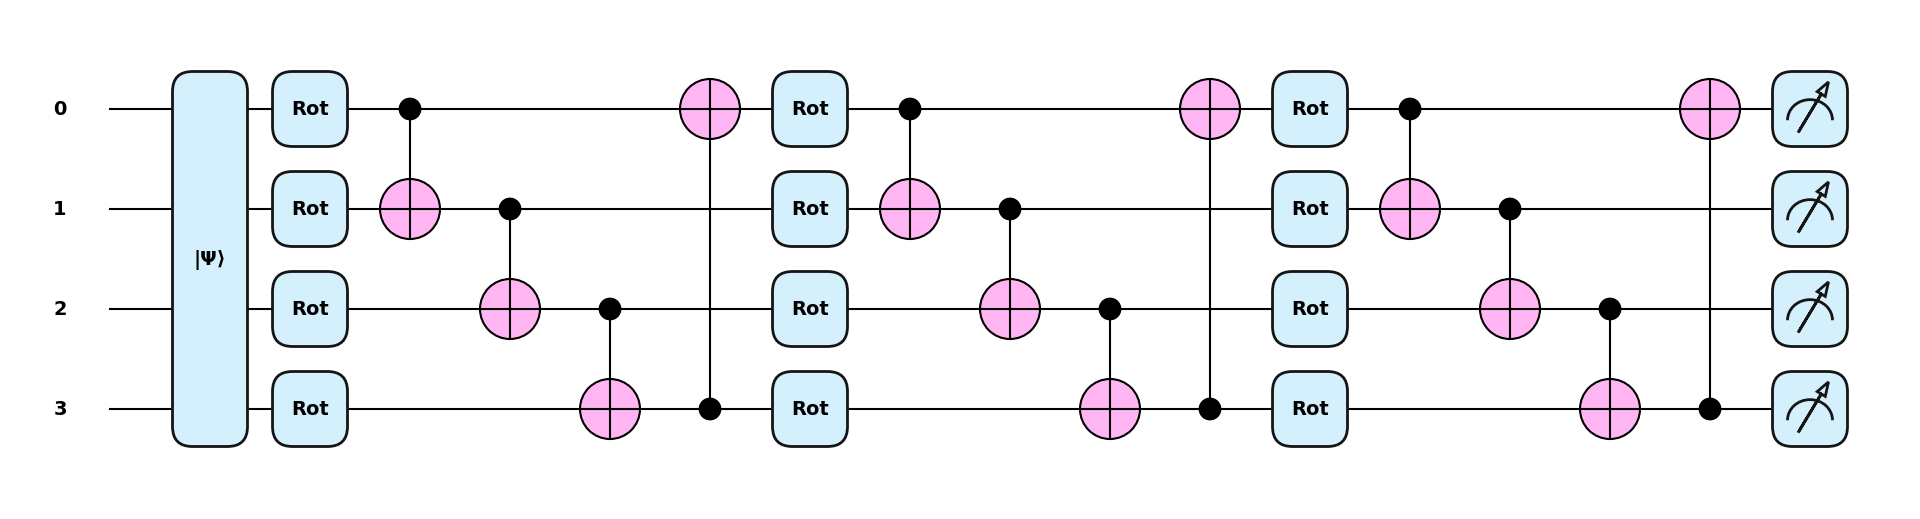

In [30]:

#* Subquestion 1.e - Testing our variational quantum classifier (VQC) on the given dataset
pnp.random.seed(42)
anp.random.seed(42)

# Defining hyperparameters of the VQC
# NOTE: The number of qubits is also a hyperparameter of the VQC, but it's defined in a previous code cell (n_qubits = 3)
num_layers = 3
epochs = 30
batch_size = 10
bias = pnp.array([0.0], requires_grad = True) # Initialize the bias of the VQC

# Defining parameters of the VQC
params = pnp.random.rand(num_layers, n_qubits, 3, requires_grad = True) # Randomly initialize the parameters of the VQC

# Drawing the quantum circuit for the variational quantum classifier
# NOTE: We use the first data point in the training data array (X_train) to draw the quantum circuit for 'n_qubits' qubits.
print(" Quantum Circuit:")
fig, ax = qml.draw_mpl(variational_circuit, style = 'pennylane')(params, X_train[0], n_qubits = n_qubits)

In [31]:

#* Model training
# We call the "train_VQC" function to train the VQC for hyperparameters defined above.
get_vectors = True
class_A_size = class_A_training_data_R3.shape[0]
num_random_points = 3
include_parameter_shift = False # If True, change respective quantum node line to include this method. REMEMBER to comment in the respective line in the quantum node definition.
new_params, bloch_vectors = train_VQC(X_train, y_train, X_test, y_test, params, bias, epochs, batch_size, n_qubits, get_vectors, class_A_size, num_random_points, include_parameter_shift)


Epoch 1 --- Training Accuracy: 69.88% --- Testing Accuracy: 68.75% --- Training Loss: 0.2084 --- Testing Loss: 0.2148
Epoch 2 --- Training Accuracy: 69.96% --- Testing Accuracy: 68.75% --- Training Loss: 0.2079 --- Testing Loss: 0.2145
Epoch 3 --- Training Accuracy: 70.99% --- Testing Accuracy: 69.65% --- Training Loss: 0.2074 --- Testing Loss: 0.2141
Epoch 4 --- Training Accuracy: 71.38% --- Testing Accuracy: 70.16% --- Training Loss: 0.2066 --- Testing Loss: 0.2135
Epoch 5 --- Training Accuracy: 71.38% --- Testing Accuracy: 70.16% --- Training Loss: 0.2061 --- Testing Loss: 0.2131
Epoch 6 --- Training Accuracy: 71.51% --- Testing Accuracy: 70.26% --- Training Loss: 0.2056 --- Testing Loss: 0.2127
Epoch 7 --- Training Accuracy: 71.63% --- Testing Accuracy: 70.26% --- Training Loss: 0.2050 --- Testing Loss: 0.2123
Epoch 8 --- Training Accuracy: 71.63% --- Testing Accuracy: 70.26% --- Training Loss: 0.2045 --- Testing Loss: 0.2120
Epoch 9 --- Training Accuracy: 71.63% --- Testing Accura

 Bloch Sphere Representation of Quantum States:

 ----------------------------- LAST 5 EPOCHS -----------------------------

 Bloch Sphere of Qubit 1 of point 1


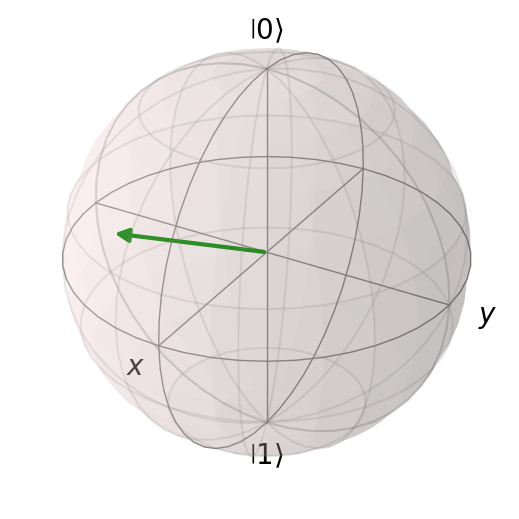

 Bloch Sphere of Qubit 1 of point 2


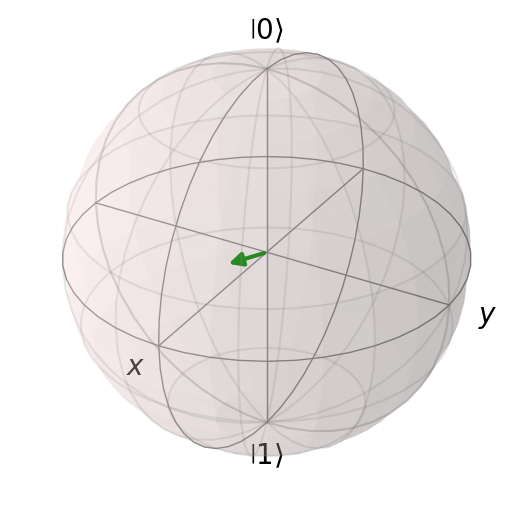

 Bloch Sphere of Qubit 1 of point 3


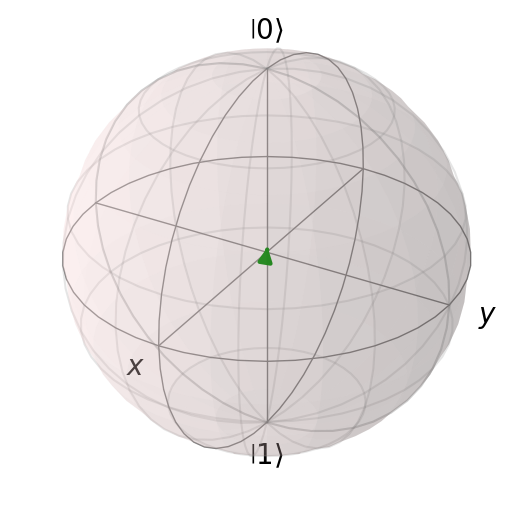

 Bloch Sphere of Qubit 1 of point 4


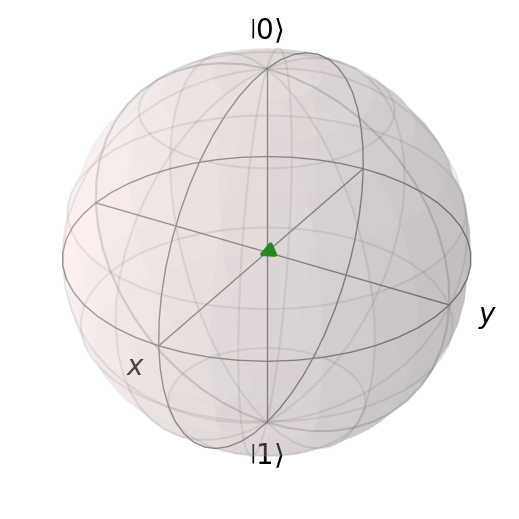

 Bloch Sphere of Qubit 1 of point 5


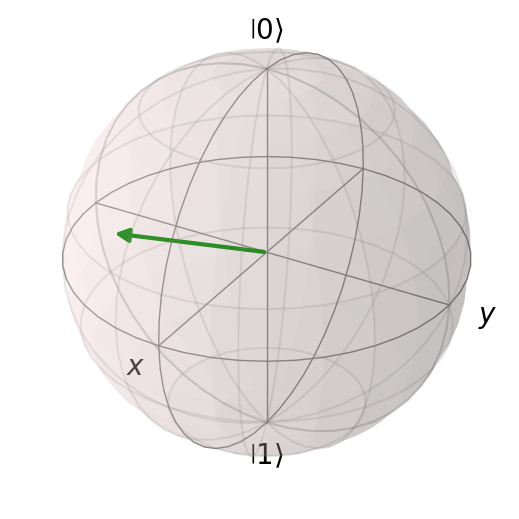

 Bloch Sphere of Qubit 1 of point 6


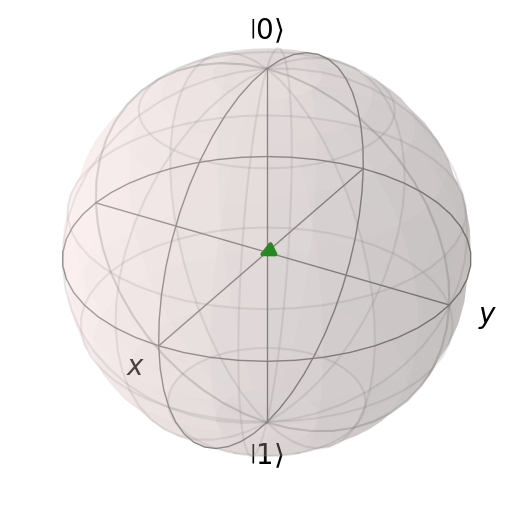

In [32]:

#* Subtopic 2 of Task 2 - Presenting geometric interpretation of the quantum states using the Bloch sphere
# In this code cell, we will plot the bloch sphere representation of the quantum states, stored as Bloch vectors in the 'bloch_vectors' array.

# Since array contains 4 * (number of random states) * (number of qubits per state), we will only plot the Bloch sphere representation of the quantum states (points) 
# for the first qubit. 
# We get the bloch vectors every 5 epochs, so in order to monitor state's transformation, by plotting the bloch spheres, we need to get the first qubit, of the EVERYTIME randomly picked points,
# every 5 epochs
# We will, conventionally, only plot the Bloch sphere representation of the quantum states for the first qubit of the randomly selected states of the *last 5 epochs*.
if get_vectors == True:
    print(" Bloch Sphere Representation of Quantum States:")
    epochs_interval = range(epochs // 5)
    last_5_epochs = max(epochs_interval) # We only care about the last 5 epochs
    num_qubits_every_5_epochs = 2 * num_random_points * n_qubits # Total number of qubits for the (2 * points per class) randomly selected states captured every 5 epochs (also includes the first epoch) 
    print(f'\n ----------------------------- LAST 5 EPOCHS -----------------------------\n')
    state_index = -1
    for i in range(last_5_epochs * num_qubits_every_5_epochs, (last_5_epochs + 1) * num_qubits_every_5_epochs, n_qubits): # We only care about plotting the first qubit of every state, so we traverse the bloch vectors array with a step of 'n_qubits'
        state_index += 1
        plot_title = f' Bloch Sphere of Qubit 1 of point {state_index + 1}'
        print(plot_title)
        plot_bloch_sphere(bloch_vectors[i], plot_title)


In [33]:

#* Task 2, Subtopic 3 - Comparing our VQC to a classical Neural Network (NN) for the given dataset
# In this code cell, we will define everything about our classical neural network (NN) model, including its architecture, used loss function and optimizers and the training process.

tf.random.set_seed(42)

# Function that defines the architecture of the classical neural network (NN) model
def neural_network_model(input_shape, adam = True, binary_crossentropy = True):
    model = Sequential()
    model.add(Input(shape = (input_shape,)))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.25))  # This layer is places in order to prevent overfitting
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.25)) 
    model.add(Dense(1, activation = 'sigmoid'))
    
    # We, also, compile the model using respective arguments given in function call.
    # Default classical NN model uses the Adam optimizer and binary cross-entropy loss function.
    # Otherwise, the nesterov momentum optimizer and mean squared error loss function are used (this was our best performing optimization and loss function combination).
    if adam and binary_crossentropy:
        optimizer = Adam(learning_rate = 0.001)
        model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    else: 
        optimizer = SGD(learning_rate = 0.001, momentum = 0.9, nesterov = True)
        model.compile(optimizer = optimizer, loss = MeanSquaredError(), metrics = ['accuracy'])
    
    return model


In [34]:

# We, now, run this classical NN model
input_shape = X_train.shape[1]
adam = True
binary_crossentropy = True
model = neural_network_model(input_shape, adam, binary_crossentropy)

# We, now, train the classical NN model
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, y_test))

# We evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# We print the test loss and test accuracy of the model
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%  --- Testing Loss: {test_loss:.4f}")


Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8517 - loss: 0.5891 - val_accuracy: 0.9742 - val_loss: 0.2339
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.1768 - val_accuracy: 0.9742 - val_loss: 0.1188
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0851 - val_accuracy: 0.9742 - val_loss: 0.0984
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0597 - val_accuracy: 0.9742 - val_loss: 0.0837
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0475 - val_accuracy: 0.9742 - val_loss: 0.0735
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0356 - val_accuracy: 0.9762 - val_loss: 0.0634
Epoch 7/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0318 - val_accuracy: 0.9762 - val_loss: 0.0540
Epoch 8/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0221 - val_accuracy: 0.

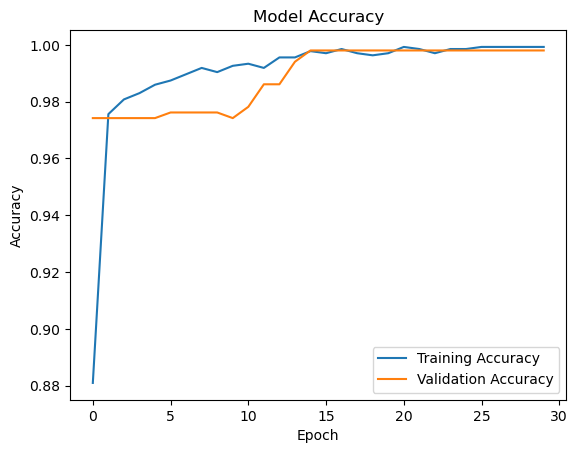

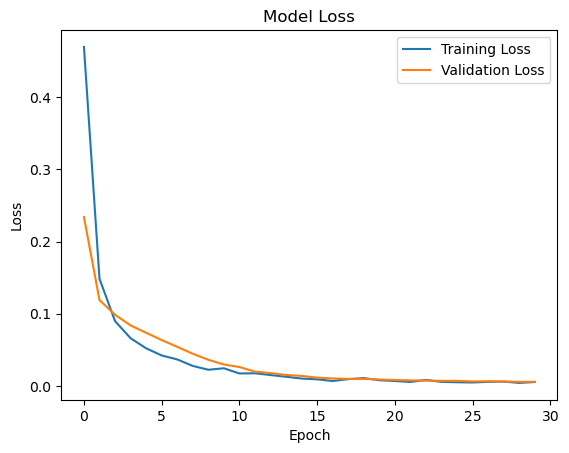

In [35]:
# In this code cell, we plot the Neural Network (NN) history, which includes the training and validation loss and accuracy of the model.

# Plotting the Neural Network (NN) accuracy scores 
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the Neural Network (NN) loss scores
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [36]:

#* Task 2, Subtopic 5 - Using our VQC model for another binary classification problem with 3 inputs

# In this code cell, we will be using the VQC model to solve the majority problem for our preexisting 3 input dataset.
# The majority problem is a binary classification problem where the output is 1, if the majority of input bits are 1, and 0 otherwise.
# We will be using the same dataset as before, but we will be changing the labels to solve this new problem.

# We, first, define our new labels
y_train_majority = np.array([np.sum(x) >= 2 for x in X_train.round().astype(int)], dtype = int)
y_test_majority = np.array([np.sum(x) >= 2 for x in X_test.round().astype(int)], dtype = int)


In [37]:
# We, now, train the VQC model on the new majority problem
# NOTE: You can comment out this line of code if you do not intend to train the VQC model on the new majority problem. 
# Execution time is about that of the previous training process.
new_params_majority, _ = train_VQC(X_train, y_train_majority, X_test, y_test_majority, params, bias, epochs, 50, n_qubits, get_vectors, class_A_size, num_random_points, include_parameter_shift)

Epoch 1 --- Training Accuracy: 84.98% --- Testing Accuracy: 86.73% --- Training Loss: 0.1610 --- Testing Loss: 0.1583
Epoch 2 --- Training Accuracy: 85.48% --- Testing Accuracy: 87.48% --- Training Loss: 0.1577 --- Testing Loss: 0.1551
Epoch 3 --- Training Accuracy: 85.91% --- Testing Accuracy: 87.67% --- Training Loss: 0.1540 --- Testing Loss: 0.1516
Epoch 4 --- Training Accuracy: 86.19% --- Testing Accuracy: 87.85% --- Training Loss: 0.1500 --- Testing Loss: 0.1478
Epoch 5 --- Training Accuracy: 86.41% --- Testing Accuracy: 88.04% --- Training Loss: 0.1457 --- Testing Loss: 0.1437
Epoch 6 --- Training Accuracy: 88.61% --- Testing Accuracy: 89.16% --- Training Loss: 0.1413 --- Testing Loss: 0.1395
Epoch 7 --- Training Accuracy: 88.83% --- Testing Accuracy: 89.35% --- Training Loss: 0.1367 --- Testing Loss: 0.1351
Epoch 8 --- Training Accuracy: 89.04% --- Testing Accuracy: 89.35% --- Training Loss: 0.1319 --- Testing Loss: 0.1306
Epoch 9 --- Training Accuracy: 98.08% --- Testing Accura

In [38]:

#* Task 3 - Using the VQC model for the 5 input dataset
# In the following code cells, we will be using the VQC model to solve the parity problem for our 5 input dataset.

# Defining the training and testing data
data_A_train = class_A_training_data_R5
data_A_test = class_A_testing_data_R5
data_B_train = class_B_training_data_R5
data_B_test = class_B_testing_data_R5

# Combine and label the data
X_train = np.vstack((data_A_train, data_B_train))
X_test = np.vstack((data_A_test, data_B_test))
y_train = np.array([np.sum(x) % 2 for x in X_train.round().astype(int)])
y_test = np.array([np.sum(x) % 2 for x in X_test.round().astype(int)])

 Quantum Circuit:


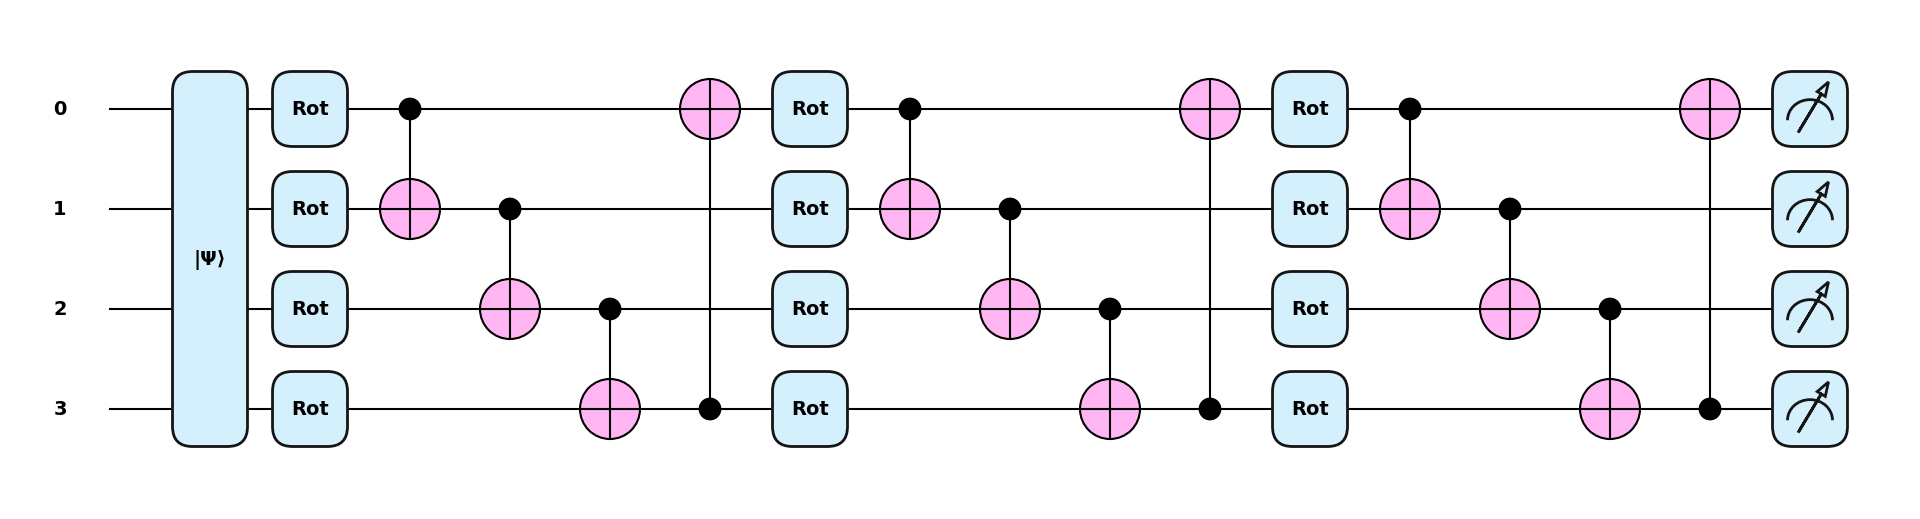

In [39]:

# In this code cell, we will be training the VQC model on the 5 input dataset to solve the parity problem.

# Defining parameters of the VQC
# Since we, now, have 5 input qubits, we will be using 5 qubits in the quantum circuit
params = pnp.random.rand(num_layers, n_qubits, 3, requires_grad = True) # Randomly initialize the parameters of the VQC

# Drawing the quantum circuit for the variational quantum classifier
# NOTE: We use the first data point in the training data array (X_train) to draw the quantum circuit for 'n_qubits' qubits.
print(" Quantum Circuit:")
fig, ax = qml.draw_mpl(variational_circuit, style = 'pennylane')(params, X_train[0], n_qubits = n_qubits)

In [40]:

# Defining some hyperparameters of the VQC
epochs = 30
batch_size = 16
bias = pnp.array([0.0], requires_grad = True) # Initialize the bias of the VQC
get_vectors = False
class_A_size = class_A_training_data_R5.shape[0]
num_random_points = 3
include_parameter_shift = False

# We, now, train the VQC model on the 5 input dataset
new_params, _ = train_VQC(X_train, y_train, X_test, y_test, params, bias, epochs, batch_size, n_qubits, get_vectors, class_A_size, num_random_points, include_parameter_shift)

Epoch 1 --- Training Accuracy: 42.49% --- Testing Accuracy: 49.74% --- Training Loss: 0.5204 --- Testing Loss: 0.4227
Epoch 2 --- Training Accuracy: 42.49% --- Testing Accuracy: 49.74% --- Training Loss: 0.5215 --- Testing Loss: 0.4234
Epoch 3 --- Training Accuracy: 42.49% --- Testing Accuracy: 49.74% --- Training Loss: 0.5223 --- Testing Loss: 0.4239
Epoch 4 --- Training Accuracy: 42.49% --- Testing Accuracy: 49.74% --- Training Loss: 0.5226 --- Testing Loss: 0.4240
Epoch 5 --- Training Accuracy: 42.49% --- Testing Accuracy: 49.74% --- Training Loss: 0.5220 --- Testing Loss: 0.4235
Epoch 6 --- Training Accuracy: 42.49% --- Testing Accuracy: 49.74% --- Training Loss: 0.5209 --- Testing Loss: 0.4226
Epoch 7 --- Training Accuracy: 43.00% --- Testing Accuracy: 49.74% --- Training Loss: 0.5191 --- Testing Loss: 0.4213
Epoch 8 --- Training Accuracy: 44.54% --- Testing Accuracy: 49.74% --- Training Loss: 0.5168 --- Testing Loss: 0.4197
Epoch 9 --- Training Accuracy: 47.11% --- Testing Accura